# Setup libraries

In [2]:
import spacy
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib notebook

# Setup important variables

In [55]:
subsample = 200 # Use a subsample of the data
nlp = spacy.load('en')
path_inputs = os.path.join('data', 'cases')
path_labels = os.path.join('data')
data_storage = {} # for caching
filenames = [filename for filename in os.listdir(path_inputs)]

# Parse all documents once and store parsed versions

In [56]:
parsed_docs = []
for filename in filenames[:subsample]:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        parsed_docs.append(doc)
data_storage['docs'] = parsed_docs

# Count the number of sentences, words and letters for each document

In [57]:
df = pd.DataFrame(columns=['Sentences', 'Words', 'Letters']).astype(np.int64)

for doc in data_storage['docs']:
    # Count
    sentences = len(list(doc.sents))
    words = 0
    letters = 0
    for token in doc:
        if not token.is_space and not token.is_punct:
            words += 1
            letters += len(token)
    # Add to dataframe
    new_entry = {'Sentences': sentences, 'Words': words, 'Letters': letters}
    df = df.append(new_entry, ignore_index=True)

# Histogram for the computed statistics

<IPython.core.display.Javascript object>


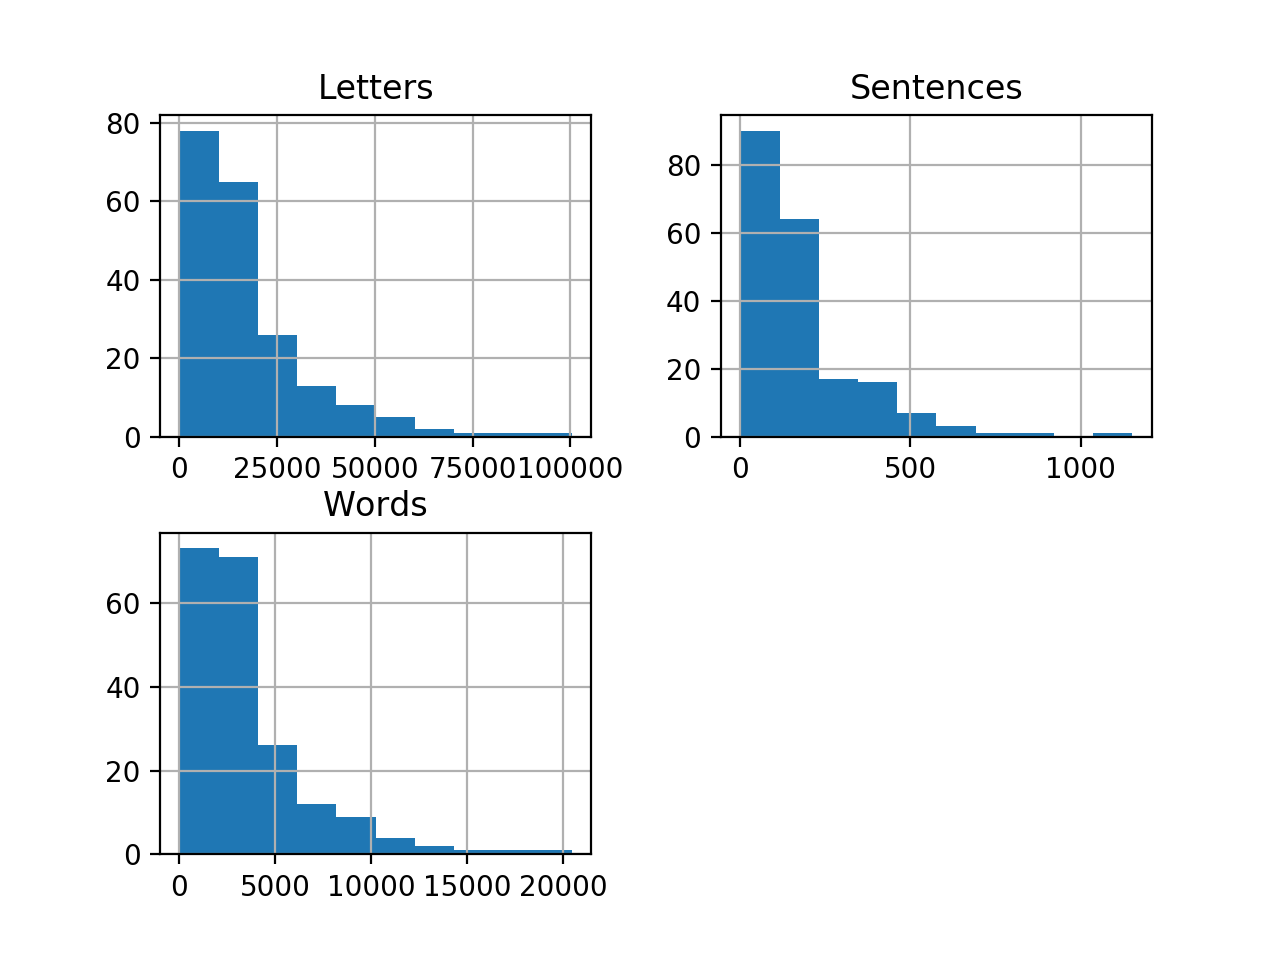

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a36785c18>,
      dtype=object)

In [58]:
df.hist()

# Count nouns, verbs, adjectives in each document

In [59]:
# first 4 letter of filenames is the year
years = list(set(([int(filename[:4]) for filename in filenames[:subsample]])))
dfPOS = pd.DataFrame(np.zeros((len(years), 3)), index=years, columns=['Nouns', 'Verbs', 'Adjectives']).astype(np.int64)
dfPOS.sort_index(inplace=True)

filenameidx = 0
for doc in data_storage['docs']:
    # Count
    nouns = 0
    adjectives = 0
    verbs = 0
    year = int(filenames[filenameidx][:4])
    for token in doc:
        if token.pos_ == 'VERB':
            verbs += 1
        elif token.pos_ == 'NOUN':
            nouns += 1
        elif token.pos_ == 'ADJ':
            adjectives += 1
    # Add to dataframe
    new_entry = dfPOS.loc[year]
    new_entry['Nouns'] += nouns
    new_entry['Adjectives'] += adjectives
    new_entry['Verbs'] += verbs
    dfPOS.loc[year] = new_entry
    filenameidx += 1

<IPython.core.display.Javascript object>


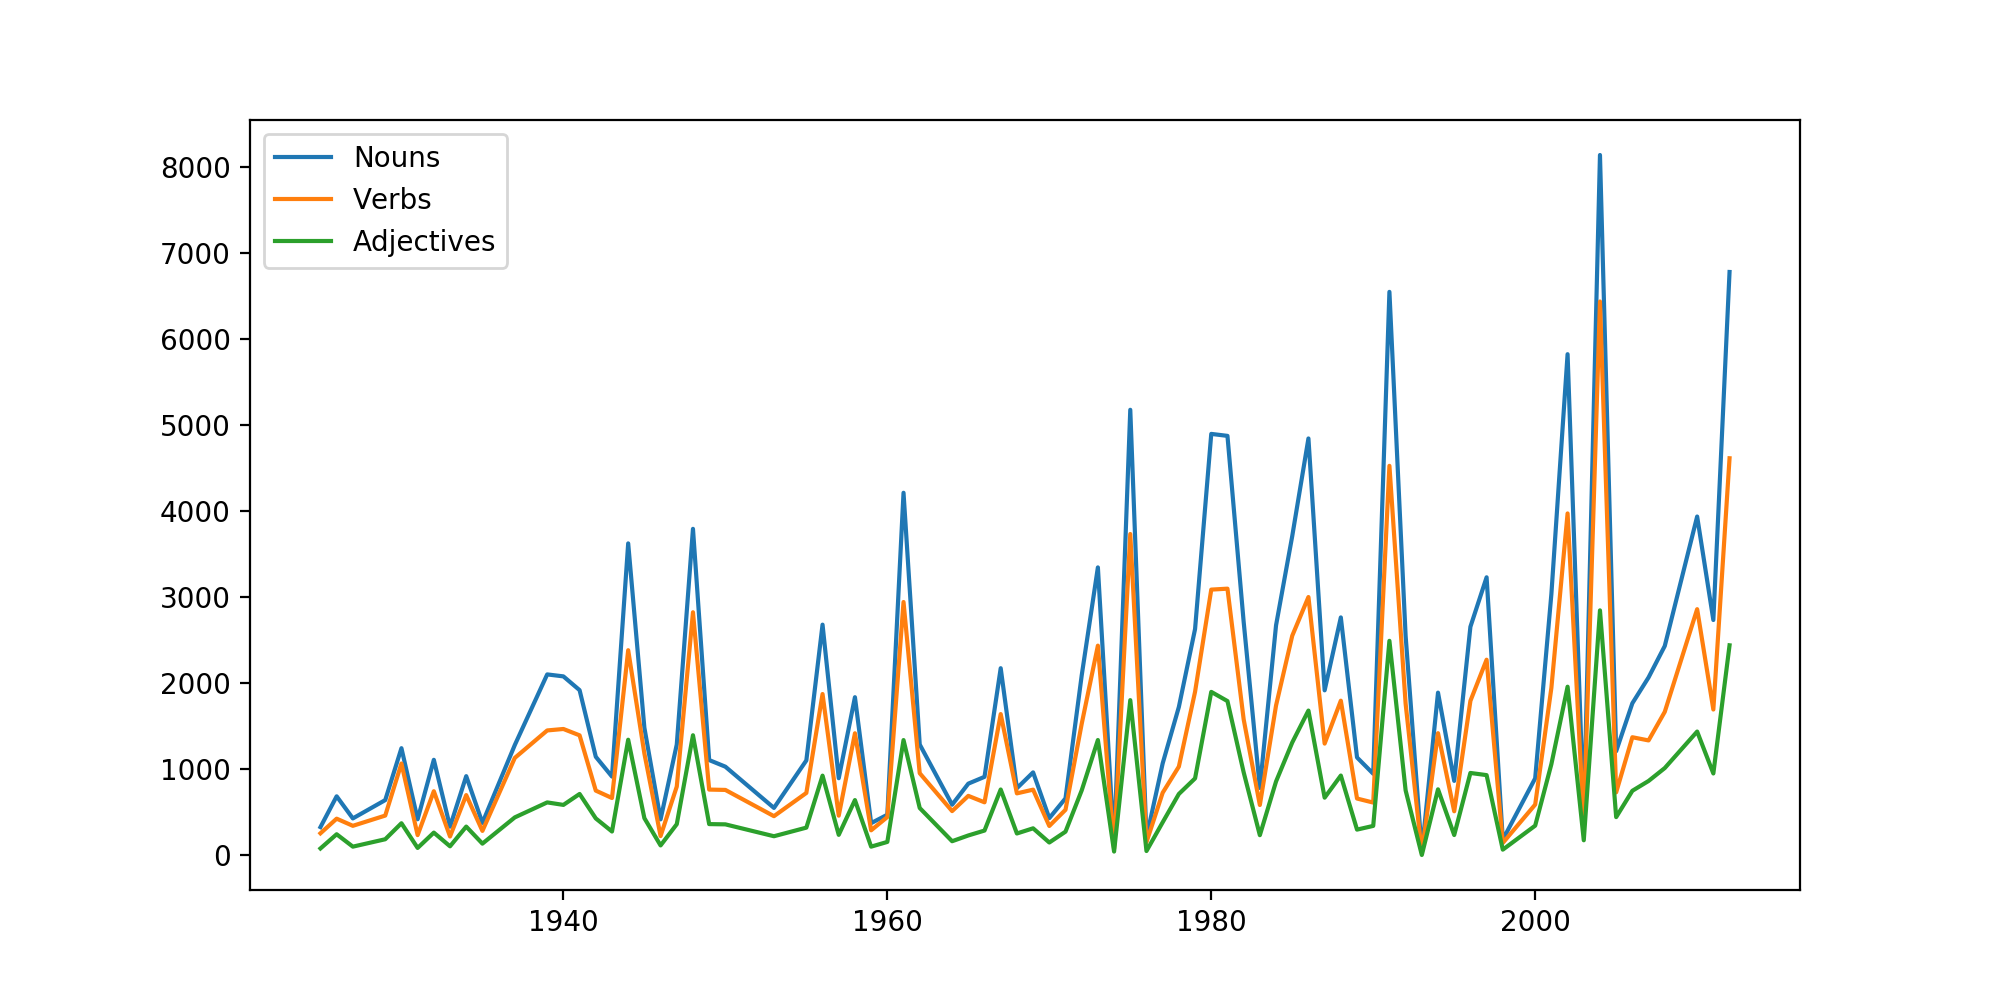

In [60]:
# Visualize POS frequency by year
dfPOS.plot(figsize=(10,5))

# Normalizing corpus

We remove punctuation as well as whitespace as they are not useful in creating trigrams.
We also remove stop words as they don't change the context we want to capture with trigrams.
We also use lemmatization to match different inflectional forms of the the same words without changing the part of speech of the word.

In [61]:
# Count occurences of each normalized trigram that ends in a noun
trigram_count = {}
# Indices
LEMMA = 0
POS = 1 # part-of-speech

for doc in data_storage['docs']:
    toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
    for i in range(len(toks)):
        if i < 2:
            continue # start from 3rd token
        pos = toks[i][POS]
        if (pos == 'NOUN'):
            trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
            if trigram in trigram_count:
                trigram_count[trigram] += 1
            else:
                trigram_count[trigram] = 1

# Select top 1000 trigrams as features

In [62]:
TOP = 1000
# sort descending by the value(count) and select the first TOP as the features
top_trigrams, _ = map(list, zip(*(sorted(list(trigram_count.items()), key=lambda x: -x[1])[:TOP])))

# Create a dataframe using the 1000 trigram features for each document

In [63]:
# Extract case names
cases = sorted(list(([filename[5:-4] for filename in filenames]))[:subsample])
# Dataframe to hold counts for each trigram feature
dfTRI = pd.DataFrame(np.zeros((len(cases), len(top_trigrams))), index=cases, columns=top_trigrams).astype(np.int64)

filenameidx = 0
for doc in data_storage['docs']:
    toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
    for i in range(len(toks)):
        if i < 2:
            continue # start from 3rd token
        pos = toks[i][POS]
        if (pos == 'NOUN'):
            trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
            if trigram in top_trigrams:
                dfTRI.at[filenames[filenameidx][5:-4], trigram] += 1
    filenameidx += 1

# Normalize the dataframe to have unit variance per feature
We keep me the mean as it is in order to maintain spasity

In [64]:
dfTRI_normalized = dfTRI / dfTRI.std()

# Load case_reversed.csv

In [65]:
df_reverse = pd.read_csv(os.path.join(path_labels, 'case_reversed.csv')).set_index('caseid').loc[cases]

# Class balance test

In [66]:
count = 0
total = 0
for index, row in df_reverse.iterrows():
    total += 1
    if row.case_reversed:
        count += 1
        
print("TOTAL:",total)
print("CLASS 0:",total-count)
print("CLASS 1:",count)

TOTAL: 200
CLASS 0: 67
CLASS 1: 133


# Split train and test data, apply logistic regression and print accuracy and F1 score

In [67]:
X_train, X_test, y_train, y_test = train_test_split(dfTRI_normalized, df_reverse, test_size=0.15)
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train.case_reversed)
y_pred = clf.predict(X_test)

print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Accuracy score {}'.format(accuracy_score(y_test, y_pred)))

F1 score: 0.5294117647058824
Accuracy score 0.4666666666666667


# GridsearchCV to choose l1 vs l2 penalty and regularization parameter C

In [68]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2'), 'C':[0.1, 2]}
logistic = LogisticRegression(solver='liblinear')
clf = GridSearchCV(logistic, parameters, cv=5)
clf.fit(X_train, y_train.case_reversed)
print("The model selected is:")
print(clf.get_params()['estimator'])
print()
print("Training score: {}".format(clf.score(X_train, y_train)))
print("Test score: {}".format(clf.score(X_test, y_test)))

The model selected is:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Training score: 0.711764705882353
Test score: 0.5


/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Plot ROC curve and calculate AUC graph for model selected

AUC:  0.4666666666666667


<IPython.core.display.Javascript object>


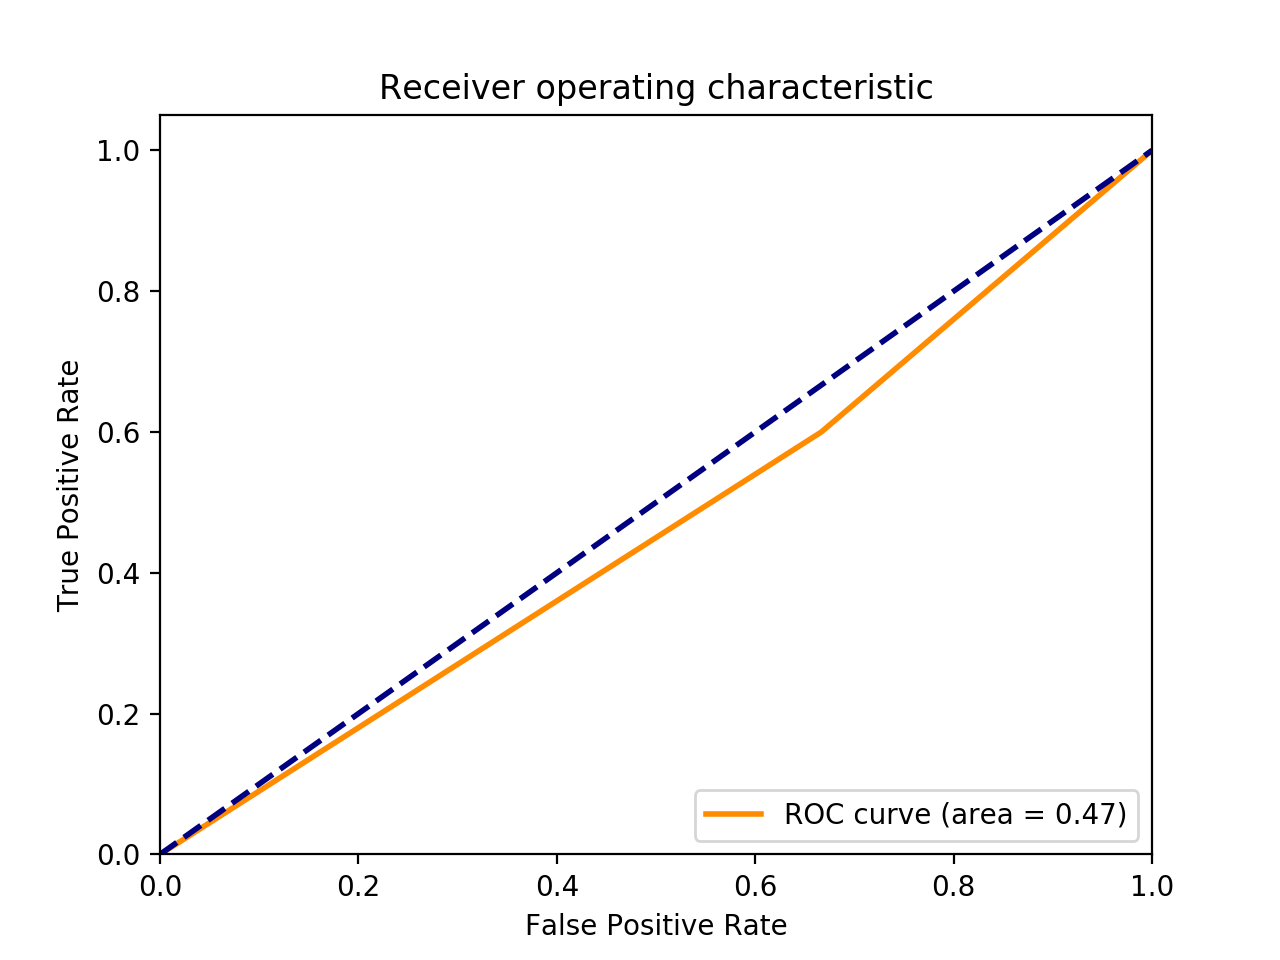

In [69]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# New dataframe where each sentence is a separate document


In [70]:
df_sent = pd.DataFrame(columns=['txt']).astype(str)
for doc in data_storage['docs']:
    for sent in doc.sents:
        df_sent = df_sent.append({'txt':sent.text}, ignore_index=True)
data_storage['sent'] = df_sent

# Compute vader compund sentiment scores and report top 10 highest- and lowest-sentiment sentences

In [71]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()
best = []
worst = []
TOPELEMS = 10 # top 10 best and worst

for _, row in data_storage['sent'].iterrows():
    sent = row.txt
    score = sentiment_analyzer.polarity_scores(sent)['compound']
    if len(best) < TOPELEMS or score > best[-1][0]:
        if len(best) >= TOPELEMS:
            best.pop()
        pos = 0
        for sc, _ in best:
            if sc > score:
                break
            pos += 1
        best.insert(pos, (score, sent))

    if len(worst) < TOPELEMS or score < worst[-1][0]:
        if len(worst) >= TOPELEMS:
            worst.pop()
        pos = len(worst)
        for i in range(len(worst)):
            sc  =  worst[len(worst) - 1- i][0]
            if sc < score:
                break
            pos -= 1
        worst.insert(pos, (score, sent))
               
            
print("BEST")
print(best)
print('------------------\n')
print("WORST")
print(worst)


BEST
[(-0.5719, 'The railway having failed to pay the amount found due by the Commission, the present suit resulted.\n'), (0.0, ' STONE , Circuit Judge.\n'), (0.0, 'This is an action to recover reparation for a freight overcharge.\n'), (0.0, 'From the judgment according reparation this appeal is brought.\n'), (0.0258, 'The matter was first presented to the Interstate Commerce Commission, which found there had been an overcharge and declared reparation.\n'), (0.3089, 'The facts here are not in dispute and are as follows: These shipments were of carloads of grain originating on various points in Minnesota, North and South Dakota, upon the line of appellant.\n'), (0.5423, 'All of them were consigned to Minneapolis and there later sent (by reconsignment without breakage of bulk in the same cars) to Superior, Wis.'), (0.5423, 'The tariffs covering rates from the points of origin to Superior did not indicate that such rates were upon any particular route.\n'), (0.8442, 'Appellant had in forc

# Calculate cosine similarity of sentences using tfidf

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
corpus = list(data_storage['sent']['txt'])
corpus_tfidf = vectorizer.fit_transform(corpus)
similarity_matrix = cosine_similarity(corpus_tfidf)

# Find 5 very similar and very dissimilar sentences according to the similarity matrix

In [73]:
NUMBER = 5
similar = []
similar_threshold = 0.50
dissimilar = []
dissimilar_threshold = 0.05

found = 0
for i in range(len(corpus)):
    for j in range(i + 1, len(corpus)):
        if similarity_matrix[i][j] > similar_threshold:
            print('SIMILAR:')
            print(corpus[i])
            print(corpus[j])
            print('Score: ', similarity_matrix[i][j])
            print()
            found += 1
            break # use a different sentence
    if found >= NUMBER:
        break
         
            
found = 0         
for i in range(len(corpus)):
    for j in range(i + 1, len(corpus)):
        if similarity_matrix[i][j] < dissimilar_threshold:
            print('DISSIMILAR:')
            print(corpus[i])
            print(corpus[j])
            print('Score: ', similarity_matrix[i][j])
            print()
            found += 1
            break # use a different sentence
    if found >= NUMBER:
        break

SIMILAR:
 STONE , Circuit Judge.

In Stone v. Stone , 632 F.2d 740 (9th Cir.1980), cert.
Score:  0.556108210380736

SIMILAR:
From the judgment according reparation this appeal is brought.

Reparation is denied."

Score:  0.5107902967890006

SIMILAR:
Appellant had in force rate tariffs prescribing certain rates from the points of origin of these shipments to Superior, rates to Minneapolis, and "proportional" rates from Minneapolis to Superior.

In the instance of each shipment there was a shorter mileage route from the point of origin to Superior, and in each instance the rate to Superior was less than the combination of the rate to Minneapolis plus the proportional rate from Minneapolis to Superior.

Score:  0.5296911411691242

SIMILAR:
In the instance of each shipment there was a shorter mileage route from the point of origin to Superior, and in each instance the rate to Superior was less than the combination of the rate to Minneapolis plus the proportional rate from Minneapolis to Su

# Use k-means clustering to assign the sentences into 20 clusters

In [74]:
from sklearn.cluster import KMeans
NCLUSTERS = 20
# Use tfidf scores for clustering
kmeans = KMeans(n_clusters=NCLUSTERS, random_state=0).fit(corpus_tfidf)

# List 5 example sentences from each cluster


In [75]:
npcorp = np.array(corpus, dtype=str)
for cluster_no in range(1,NCLUSTERS,1):
    print('Cluster {}'.format(cluster_no))
    this_cluster = npcorp[kmeans.labels_ == cluster_no]
    if this_cluster.shape[0] > 5:
        this_cluster = np.random.choice(this_cluster, 5)
    for sent in this_cluster:
        print(sent)

Cluster 1
On that point Mr. Justice Powell said, "[W]e find no constitutional basis for holding that the speedy trial right can be quantified into a specified number of days or months."

[**28] that students would learn about his holding office, or opposing the legitimation of no-fault divorce because a teacher might allude to that fact if a course in societal structure were taught to graduating seniors.

Every person who shall monopolize, or attempt to monopolize, or combine or conspire with any other person or persons, to monopolize any part of the trade or commerce among the several States, or with foreign nations, shall be deemed guilty of a misdemeanor, and, on conviction thereof, shall be punished by fine not exceeding $5,000, or by imprisonment not exceeding one year, or by both said punishments, in the discretion of the court."

The libelant knew that the work had not been completed at 5 o'clock November 11, but gave instructions: "If no further notice by Public Service or Gove